>Импортирую библиотеки

In [1]:
import requests
import pandas as pd
import time
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt

# Первая часть ДЗ

>Скачиваю ID объектов

In [ ]:
list_id = []
urls = [f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={i-100}&limit=100&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0' for i in range(101,11001,100)]
for i in range(len(urls)):
    res = requests.get(urls[i]).json().get('data').get('list')
    for j in res:
        list_id.append(j.get('objId'))

>По полученным ID получаю полную информацию об объекте

In [ ]:
%%time
url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/'
data = requests.get(url+str(list_id[0])).json().get('data')

tmp = {}
for i in list(data.items()):
    tmp[i[0]] = [i[1]]
data.update(tmp)
df = pd.DataFrame.from_dict(data)

for i in range(1,100):
    data_tmp = requests.get(url+str(list_id[i])).json().get('data')

    tmp = {}
    for i in list(data_tmp.items()):
        tmp[i[0]] = [i[1]]
    data_tmp.update(tmp)
    df = pd.concat([df,pd.DataFrame.from_dict(data_tmp)])

>Сохраняю полученные данные в файл

In [ ]:
df.to_csv('full_data.csv', index = False, encoding="utf-8-sig")

# Вторая часть дз

>Удаляю ненужную информацию

In [3]:
df = pd.read_csv('full_data.csv')
df = df.drop(['metro', 'complexShortNm', 'airQualityIndexValue', 'greenAreaIndexValue', 'transportDistIndexValue', 'transportDistIndex', \
              'developer', 'rpdPdfLink', 'photoRenderDTO', 'miniUrl', 'quartography', 'generalContractorNm', 'objLkSaleDepEmail','nameObj',\
             'objLivCeilingHeight'], axis = 1)
df = df.dropna()
df = df.reset_index(drop=True)

>Получаю данные о названиях региона (сайт искал сам), попутно создаю множество переменных и считаю среднюю стоимость по регионам .Сделал много лишней работы, потому что не прочел задание и не видел ссылки по регионам на дом.ру. Нашел сам подходящий сайт и парсил тамошнюю таблицу

In [4]:
reg_list = list(set(df['region']))
reg_price = []
for i in reg_list:
    tmp_df = df[df['region'] == i]
    reg_price.append(int(tmp_df['objPriceAvg'].mean()))
    
av_price_by_reg = list(zip(reg_list,reg_price))

reg_names = requests.get('http://bigkarta.ru/regiony-russia.htm')
reg_names.encoding = 'cp1251'
reg_names = reg_names.text.replace('<b>', '').replace('<p>','')
reg_names = reg_names.split('\n')[28:114]
num_reg = []
name_reg = []
for i in range(len(reg_names)):
    num_reg.append(int(reg_names[i][0:2]))
    if reg_names[i][reg_names[i].find('>')+1:reg_names[i].find('r')-2][0] == ' ':
        name_reg.append(reg_names[i][reg_names[i].find('>')+2:reg_names[i].find('r')-2])
    else:
        name_reg.append(reg_names[i][reg_names[i].find('>')+1:reg_names[i].find('r')-2])
    
num_and_name = list(zip(num_reg, name_reg))
name_and_price = []
for i in range(len(av_price_by_reg)):
    for j in range(len(num_and_name)):
        if av_price_by_reg[i][0] == num_and_name[j][0]:
            name_and_price.append((num_and_name[j][1], av_price_by_reg[i][1]))

<BarContainer object of 76 artists>

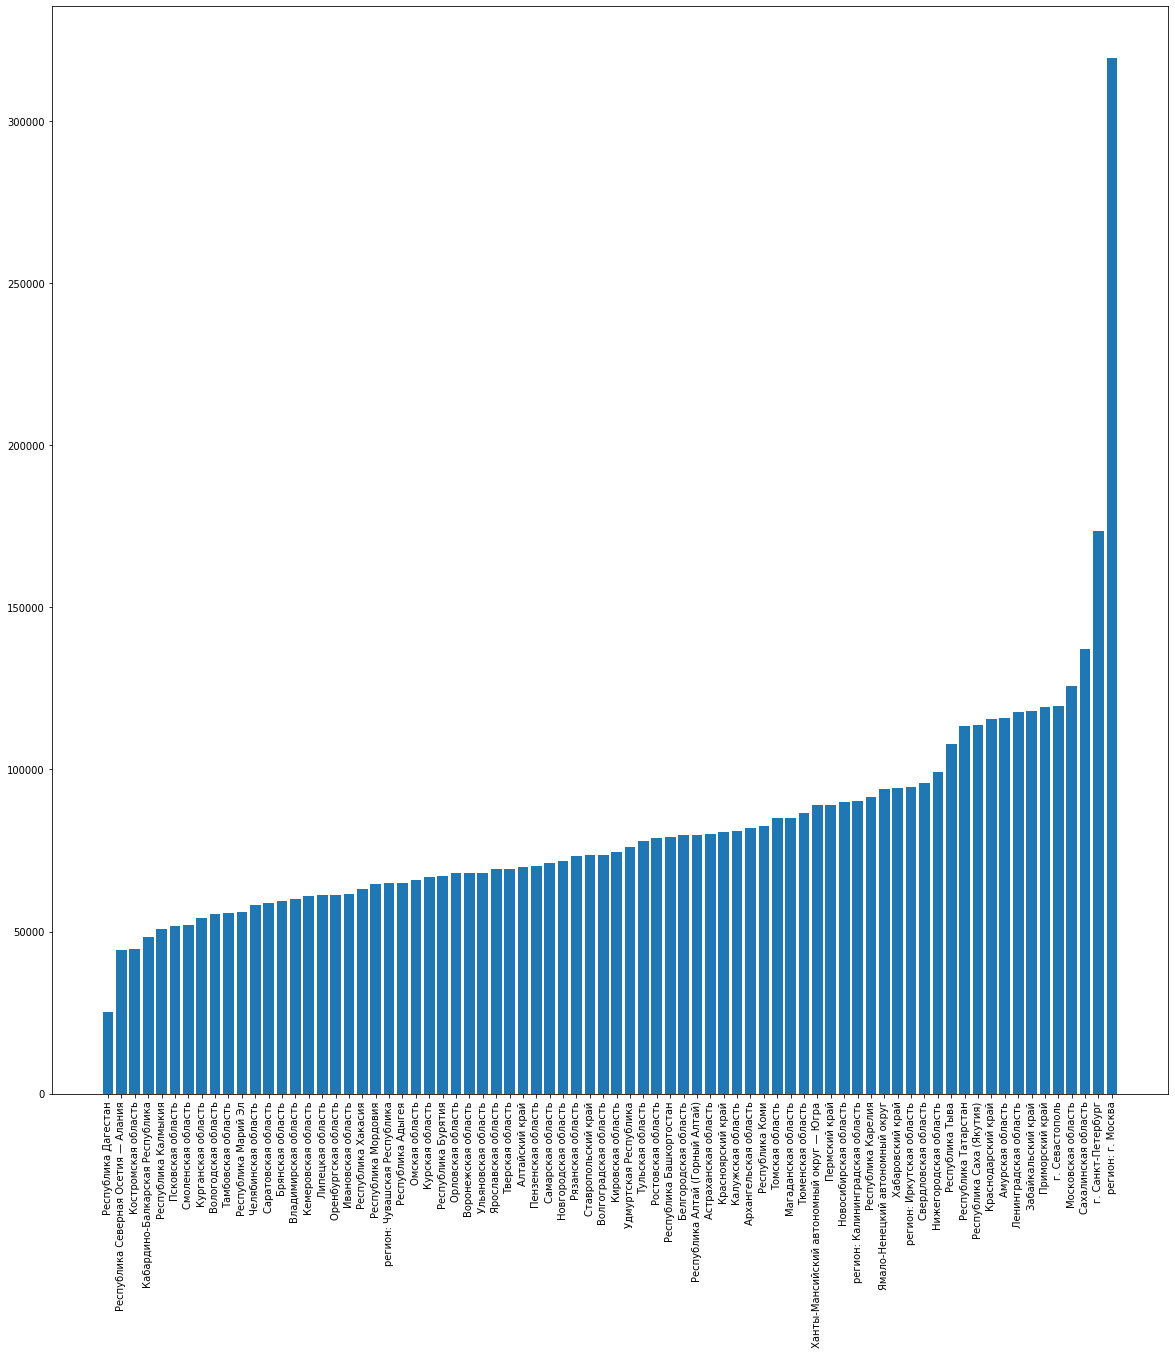

In [20]:
name_and_price.sort(key = lambda x: (x[1], x[0]))
n,p = list(zip(*name_and_price))
fig = plt.figure(figsize=(20,20))
plt.xticks(rotation=90)
plt.bar(n,p)

>Создаю словарь с номером региона и его ID

In [5]:
num_and_name_dict = {}
for i in num_and_name:
    num_and_name_dict[i[0]] = i[1]
num_and_name_dict[20] = 'Республика Чечня'
num_and_name_dict[91] = 'Республика Крым'

>Считаю данные по кол-ву жилья по годам и регионам

In [93]:
years = {}
for i in reg_list:
    tmp_df = list(df[df['region'] == i]['objReady100PercDt'])
    tmp_list = {}
    for j in range(2022,2027):
        count = 0
        for l in range(len(tmp_df)):
            if tmp_df[l][:4] == str(j):
                count += 1
        tmp_list[j] = count
    years[num_and_name_dict[i]] = tmp_list
years['ХМАО'] = years.pop('Ханты-Мансийский автономный округ — Югра')

>Визуализирую данные по жилью (года и регионы). Тут есть нюанс, я сделал именно сколько в каждом регионе в год. А не отдельно по годам и отдельно по регионам. Не знаю как верно, в третьей части задания сделал иначе на всякий случай.

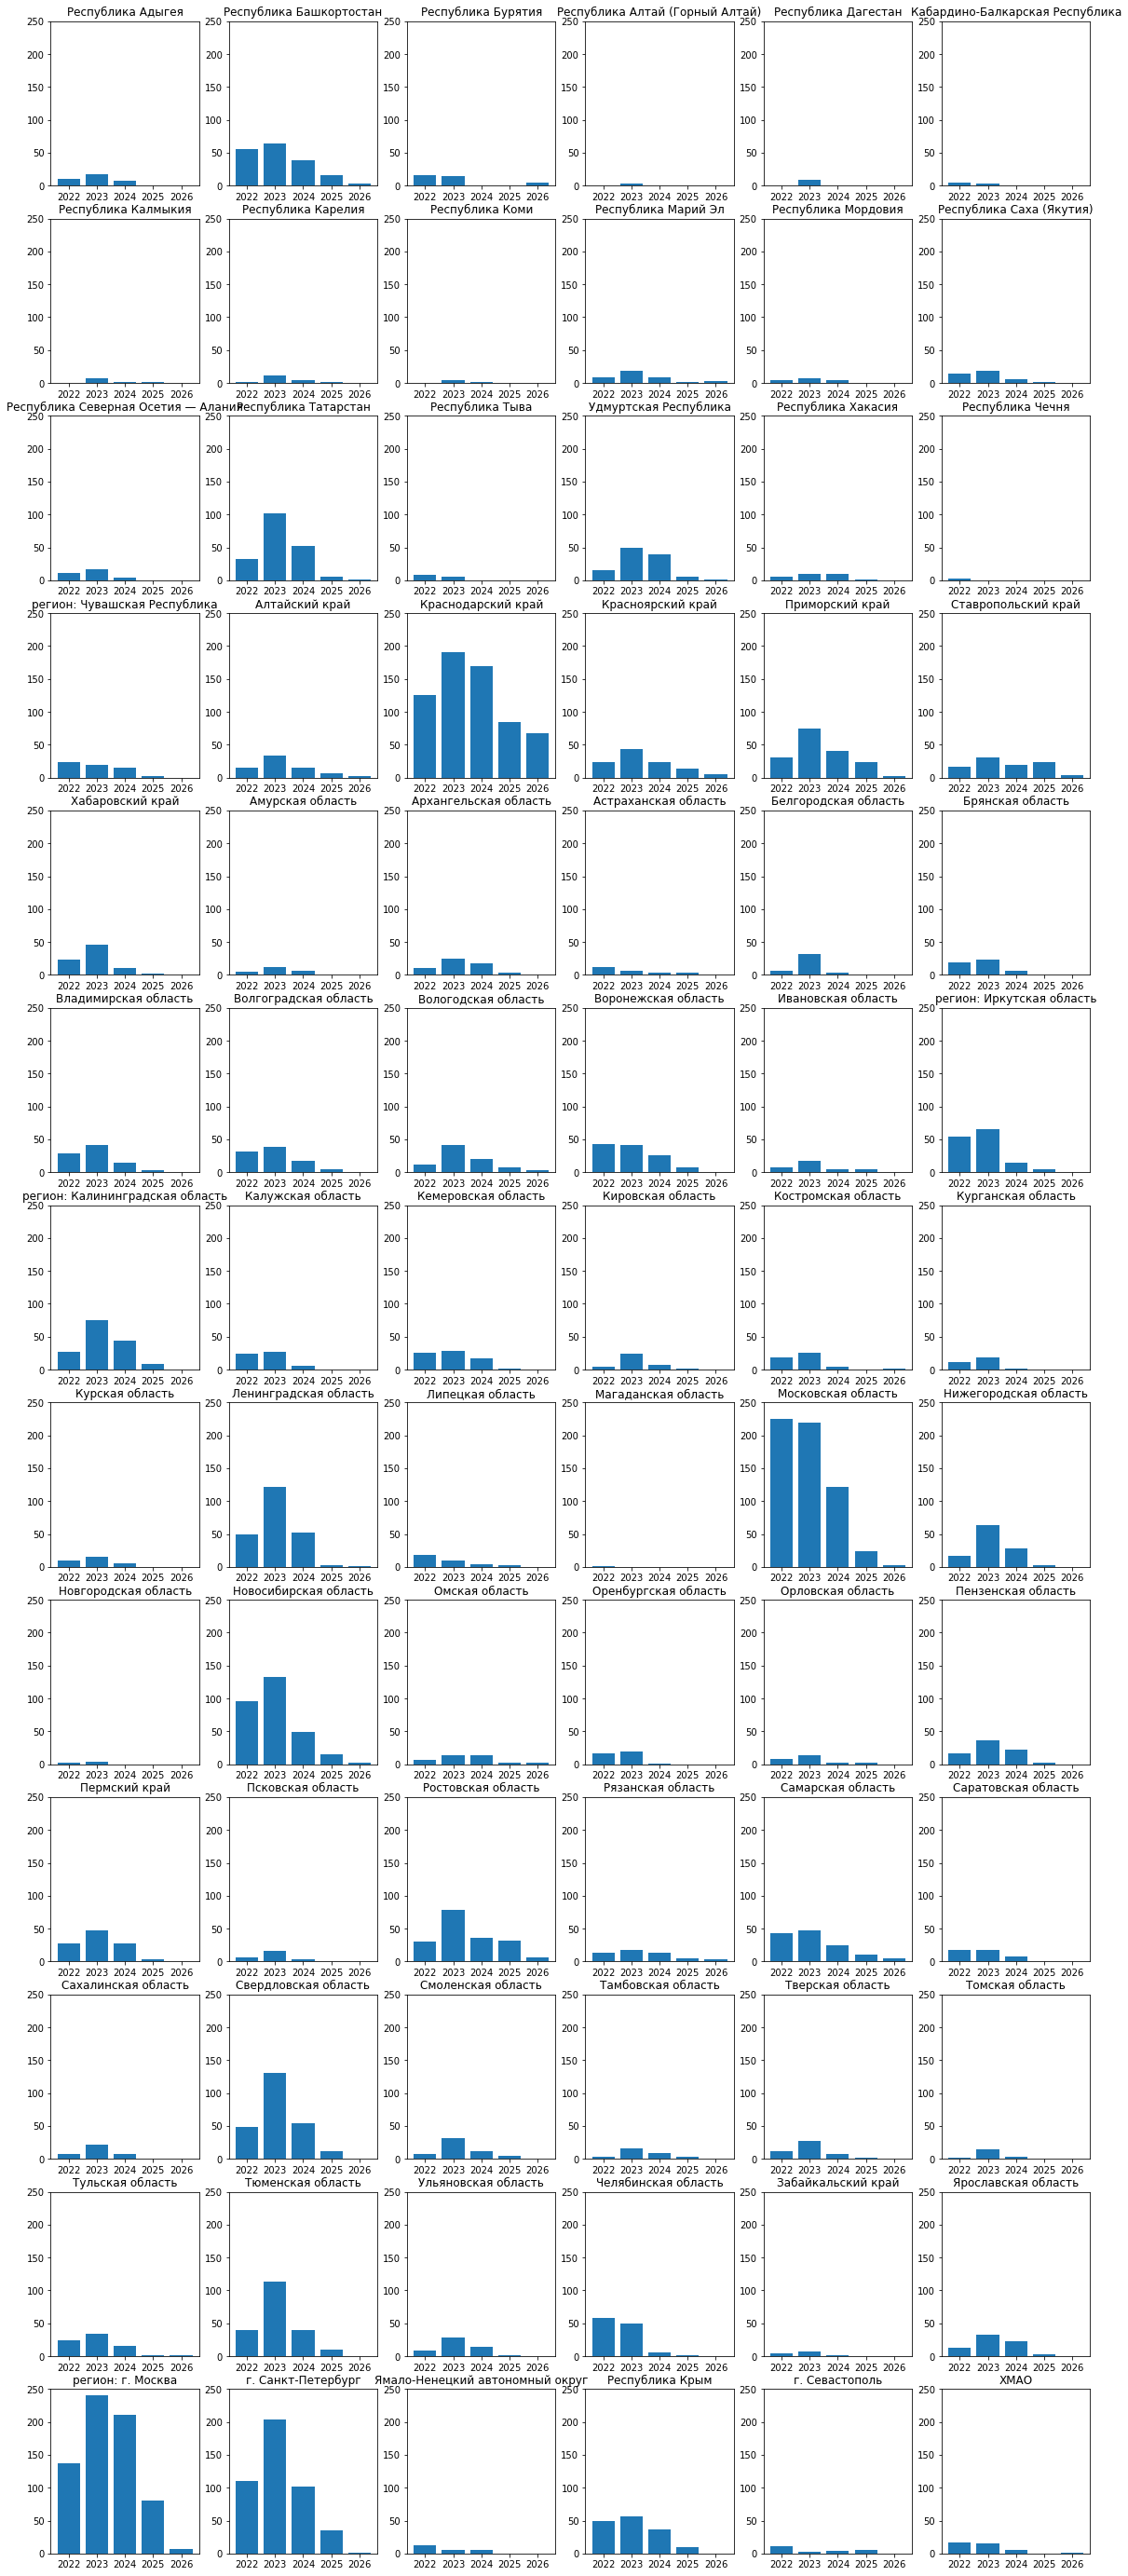

In [94]:
col = 1
fig = plt.figure(figsize=(20,50))
for i in years:
    plt.subplot(13,6,col)
    plt.title(i)
    plt.ylim([0, 250])
    values = list(years[i].values())
    keys = list(years[i].keys())
    plt.bar(range(len(years[i])),values,tick_label=keys)
    col += 1

# Третья часть дз

>Между выполнением второй и третьей части дз прошел месяц, так что я где-то поумнее сделал, где-то нет) И еще я нашел ссылку на дом.ру и мне подсказали пару функций, которые существенно облегчают жизнь, также стал использовать преимущественно словари, набираюсь знаний. Я вообще редко себе жизнь упрощаю, но тут решил)

>Тут всего 100 объектов, поэтому именно информация будет неполная. Но полная инфа есть сверху. Еще можно было сделать с помощью асинхронной выгрузки данных, я потом для себя сделал уже(

In [2]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 1
        self.limit_ = 100
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'

    def get_ids(self):
        paramz = {
            'offset': self.offset_,
            'limit': self.limit_,
            'sortField':'devId.devShortCleanNm',
            'sortType':'asc',
            'objStatus':'0'
        }
        res = requests.get(self.url, params=paramz)
        full_data = res.json().get('data').get('list')
        ids = []
        for x in full_data:
            ids.append(x.get('objId'))
        return ids

    def show_ids(self):
        print(self.get_ids())

In [3]:
class ObjectInfoExtractor:
    def __init__(self, ids):
        self.objectids = ids
        self.df_data = pd.DataFrame()
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/dictionary/regions'
        self.names = {}

    def load_data(self):
        for i in range(len(self.objectids)):
            url_obj = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{self.objectids[i]}'
            try:
                res_obj = requests.get(url_obj)
                data = res_obj.json()
                self.df_data = pd.concat([self.df_data, pd.json_normalize(data.get('data'), max_level=1)])
            except:
                continue
        region = requests.get(self.url).json()
        for reg in region:
            self.names[reg['id']] = reg['name']
        self.df_data['region'] = self.df_data['region'].apply(lambda x: self.names[x])
        return self.df_data.reset_index(drop=True)

In [4]:
ids = DomIdLoader().get_ids()
print(ids)

[13391, 13397, 13383, 13398, 13399, 36912, 44076, 10891, 39176, 39175, 27049, 41420, 41421, 30292, 19457, 18709, 18708, 21534, 21536, 21535, 21537, 42192, 27542, 20524, 24093, 27798, 27801, 27802, 27806, 27803, 23863, 23862, 23864, 27808, 45249, 21720, 33899, 17707, 17712, 33745, 47610, 44489, 44621, 46571, 15888, 15885, 15886, 15890, 15889, 15891, 35324, 41612, 45256, 41613, 41614, 41615, 41616, 41617, 41618, 41621, 41619, 24819, 24818, 41620, 45772, 18136, 44752, 37465, 33525, 33095, 33096, 33097, 33098, 33099, 33100, 33101, 33123, 33177, 33135, 33184, 33186, 33189, 33106, 33107, 33144, 33169, 13118, 33134, 33176, 33180, 33183, 33185, 33190, 33137, 33191, 33192, 33193, 33138, 33139, 33143]


In [5]:
f = ObjectInfoExtractor(ids).load_data()
f.head()

,id,pdId,region,address,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,...,greenAreaIndexValue,developer.bankruptStage,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,13391,28101,Тюменская область,"г Тюмень, ул Профсоюзная",3,12,44,2022-12-31,Другое,По желанию заказчика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13397,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",6,12,65,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13383,28105,Тюменская область,г Тюмень,4,20,68,2022-12-31,Другое,По желанию заказчика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13398,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",7,10,43,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13399,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",1,1,0,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
class Saver:
    def __init__(self, data):
        self.data = data

    def save_csv(self):
        self.data.to_csv('data.csv')

    def save_sql(self):
        self.data.to_sql('data', con=engine)
    
    def save_xl(self):   
        self.data.to_excel("data.xlsx")  

>Здесь мне подсказали как это всю визуализацию в пару строк реализовать

In [6]:
class Visualizer:
    def __init__(self,data):
        self.data = data

    def make_boxplot(self):
        dict_feature_1 = {
            'Средние цены за квадратный метр': 'objPriceAvg',
            'Этажность домов': 'objFloorCnt',
            'Количество квартир': 'objFlatCnt',
            'Жилая площадь дома': 'objSquareLiving',
            'Количество парковочных мест': 'objElemParkingCnt'
        }
        for key, value in dict_feature_1.items():
            mean_feature = self.data.loc[self.data[value].notna()].groupby('region')[value].mean()
            plt.subplots(figsize=(20, 8))
            mean_feature.sort_values().plot(kind='bar')
            plt.title(key)
            
        self.data['objReady100PercDt'] = pd.to_datetime(self.data['objReady100PercDt'], format="%Y/%m/%d")
        self.data.loc[:, 'objReady100PercDt'] = self.data.loc[:, 'objReady100PercDt'].dt.year
        dict_feature_2 = {'Объем вводимого жилья по регионам': 'region',
                          'Объем вводимого жилья по годам': 'objReady100PercDt'}
        for key, value in dict_feature_2.items():
            volume = self.data.groupby(value)[value].count()
            plt.subplots(figsize=(20, 8))
            volume.sort_values().plot(kind='bar')
            plt.title(key)
            
        plt.show()

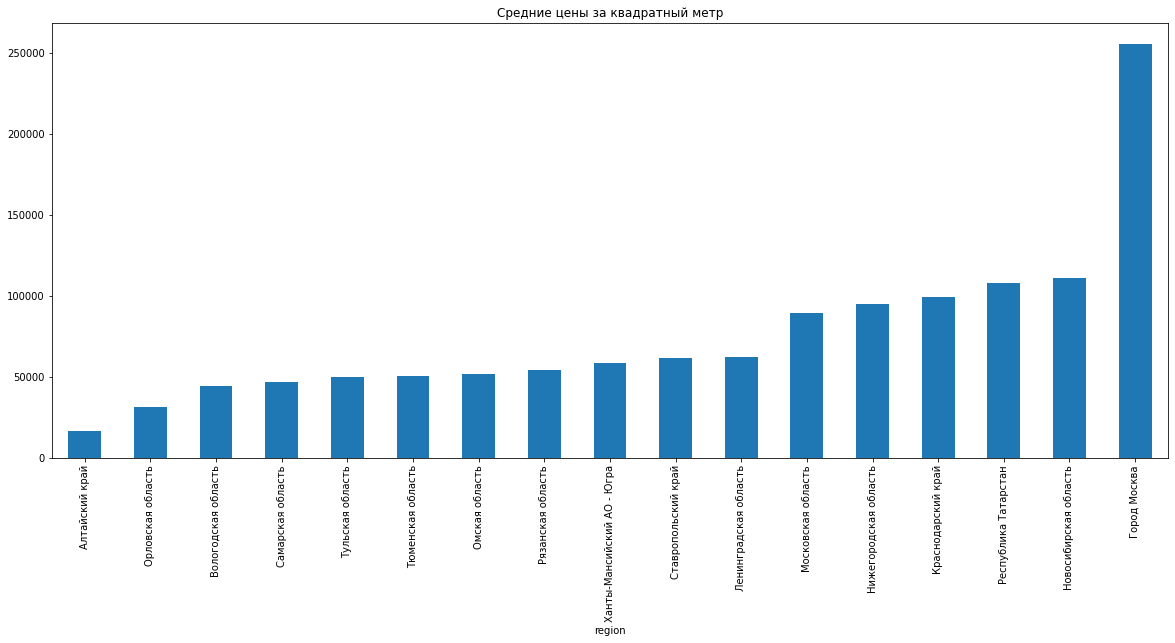

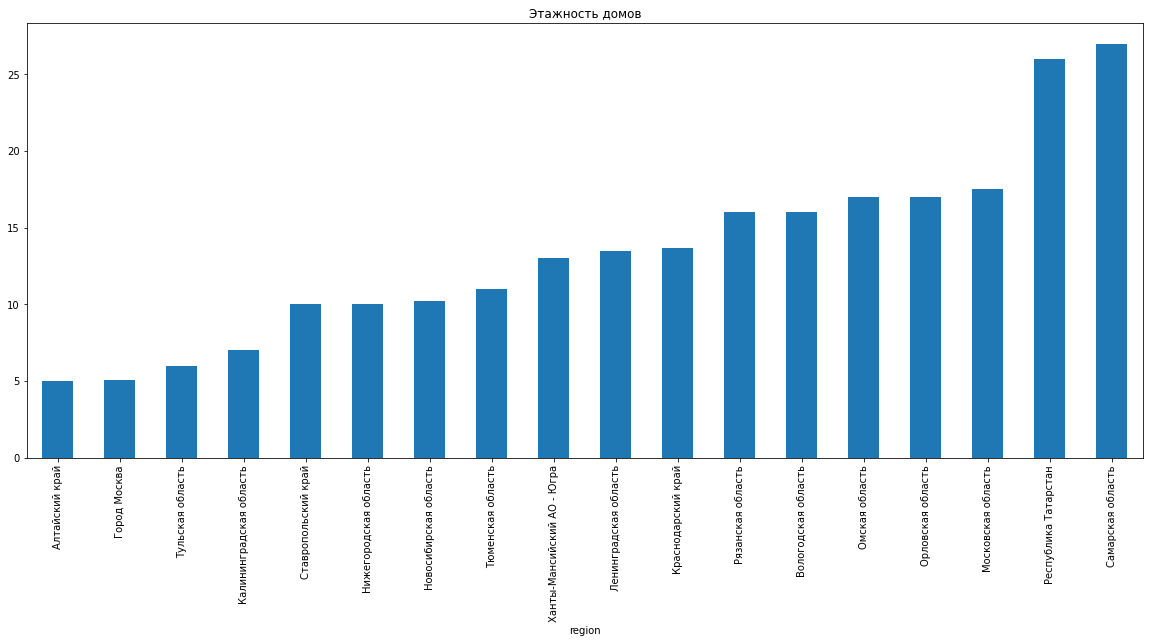

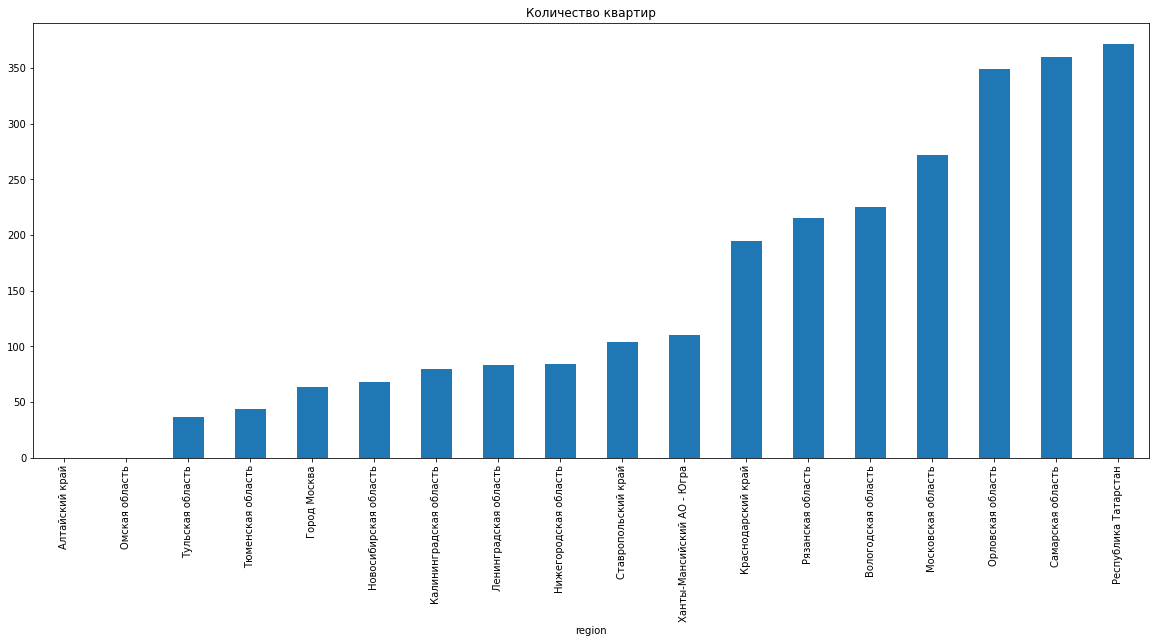

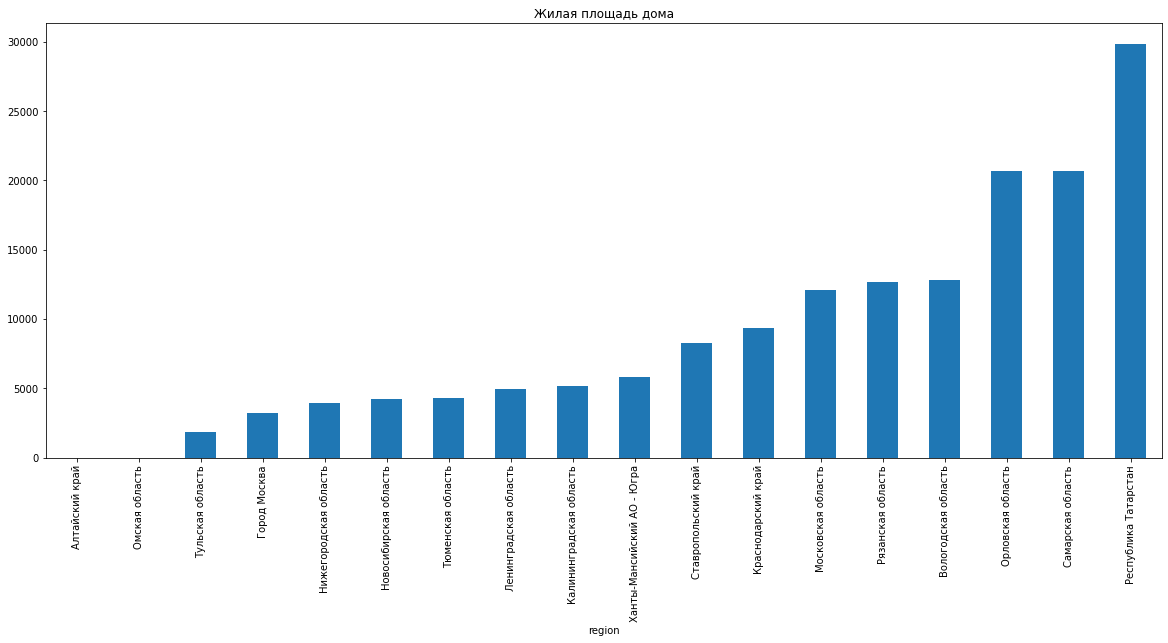

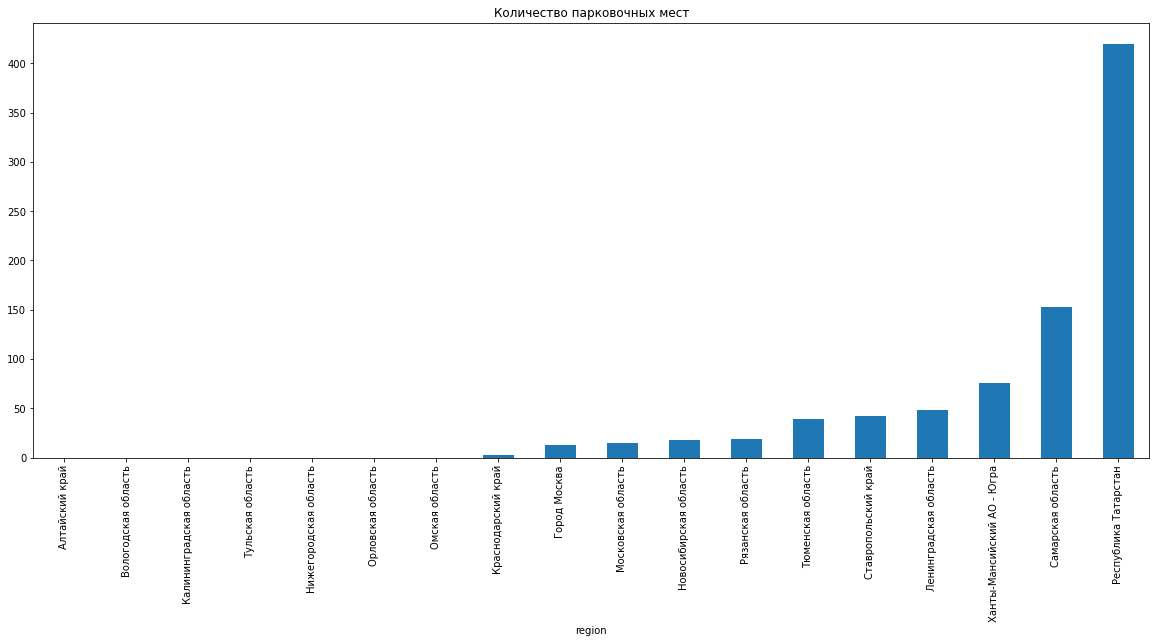

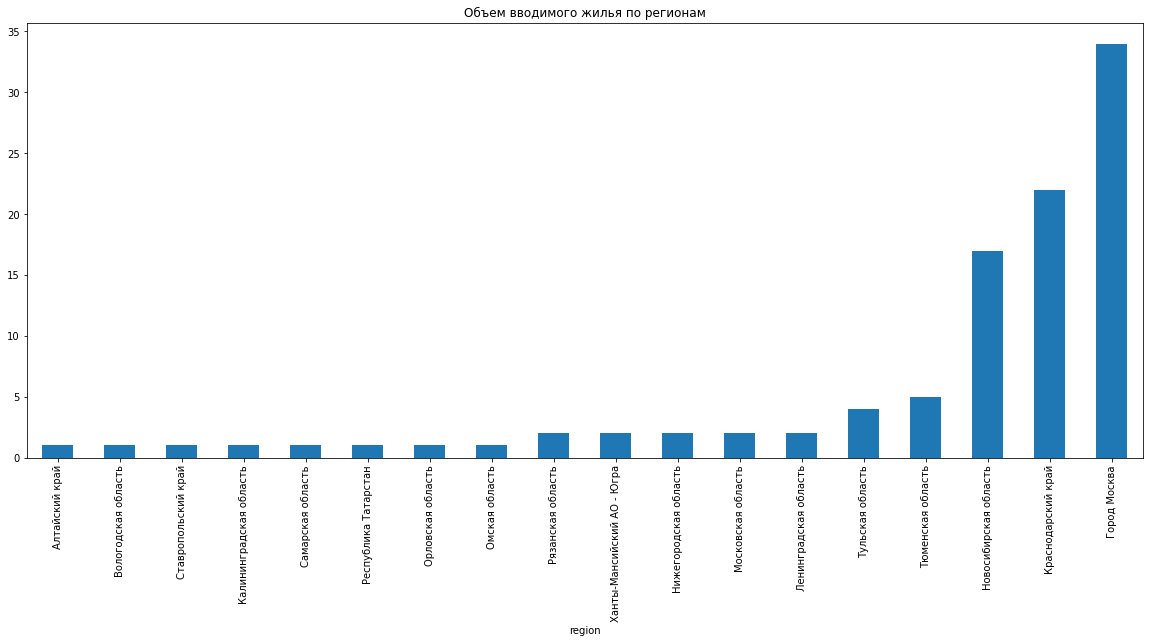

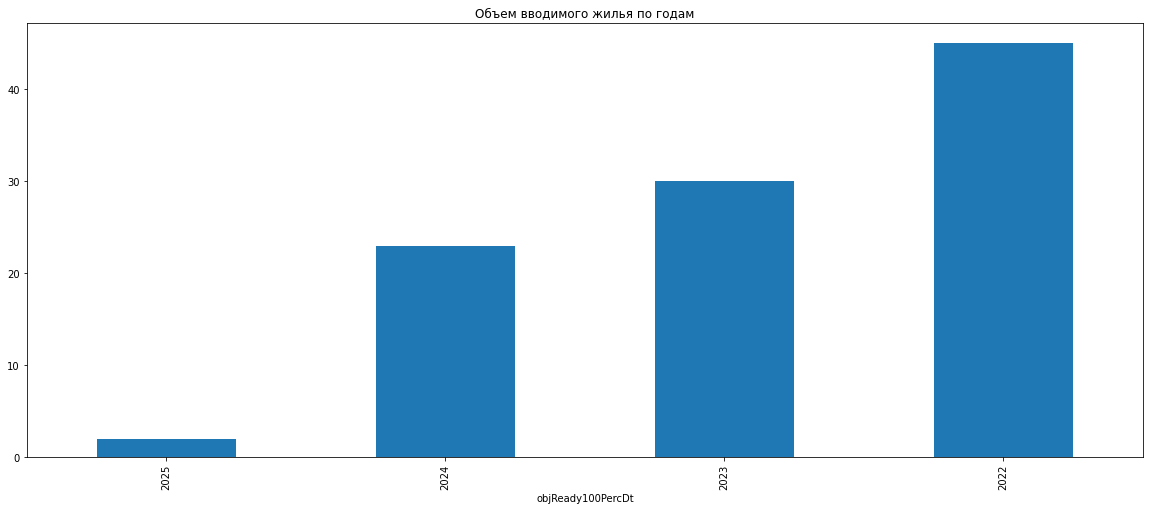

In [7]:
fig = Visualizer(f)
fig.make_boxplot()

По поводу анализа. Очевидно, что парктически во всех показателях лидирует Москва, Питер (цены за кв. метр, кол-во парковочных мест, объем вводимого жилья) и в целом Европейская часть России. Потому что самая выскоая плотность населения именно там. Но также точечно развивается и востояная часть России (к востоку от Урала), а именно Новосибирск, Екатеринбург. Также Свердловская область по всем графикам входит в топ 10, кроме цены за квадратный метр, очевидно, регион развивающийся. На счет приморья что-то сказать сложно, регион переферийный, относительно столицы. Судя по всем графикам примерно 15-20 место.